# Modelo Naive Bayes (MultinomialNB) para detección de mensajes tóxicos

En este notebook entrenamos un modelo clásico de **Naive Bayes (MultinomialNB)** para detectar
comentarios tóxicos (`IsToxic`) en el dataset preprocesado:

- Cargamos el dataset ya **preprocesado** (`data/preprocessing_data/youtoxic_english_1000_clean.csv`).
- Usamos como texto base la columna `text_classic`.
- Incorporamos **5 features numéricas** ya generadas en el preprocesado::
  - `text_len_classic`
  - `word_count_classic`
  - `uppercase_ratio`
  - `exclamation_count`
  - `hate_words_count`
- Construimos un **pipeline de scikit-learn** con:
  1. `TfidfVectorizer` (``TF-IDF`) sobre el texto.
  2. Concatenación (o paso directo `passthrough`) con las features numéricas.
  3. Clasificador `MultinomialNB`.

Al final del notebook:

- Entrenaremos el modelo con un **train/test split (80/20)**.
- Evaluamos métricas estándar: accuracy, precision, recall, F1, ROC-AUC y matriz de confusión.
- Mostramos gráficos:
  - Matriz de confusión
  - Curva ROC
- Guardaremos:
  - El modelo entrenado (`backend/models/<nombre_modelo>.pkl`)
  - Los resultados de las métricas en JSON (`.json`) en `data/results/` (`data/results/<nombre_modelo>.json`) siguiendo el formato acordado para el resto de notebooks de modelos y facilitar la comparación.


### 1. Importación de librerías y configuración

En esta celda:

- Importamos librerías para:
  - Manejo de rutas y fechas (`pathlib`, `datetime`)
  - Manejo de datos (`pandas`, `numpy`)
  - Machine Learning clásico con scikit-learn:
    - División en train/test
    - Vectorización de texto (`TfidfVectorizer`)
    - Combinación de columnas (`ColumnTransformer`, `Pipeline`)
    - Clasificador Naive Bayes (`MultinomialNB`)
    - Cálculo de métricas
  - Visualización (`matplotlib`)
  - Persistencia de modelos (`joblib`)
  - Guardado de resultados en JSON (`json`)
- Definimos variables de configuración:
  - Columna objetivo (`TARGET_COL`)
  - Columna de texto (`TEXT_COL`)
  - Lista de features numéricas
  - Nombre del modelo
  - Semilla (`RANDOM_STATE`) para reproducibilidad.


In [119]:
# === 1. Import libraries and global configuration ============================

import json  # To save metrics in JSON format
from datetime import datetime  # To generate ISO timestamp
from pathlib import Path  # To handle file system paths

import numpy as np  # Numerical operations
import pandas as pd  # DataFrame handling

# Machine Learning (scikit-learn)
from sklearn.model_selection import train_test_split  # Train/test split
from sklearn.feature_extraction.text import TfidfVectorizer  # Text vectorization
from sklearn.compose import ColumnTransformer  # Combine text + numeric features
from sklearn.pipeline import Pipeline  # Build end-to-end ML pipeline
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier for text

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV  # Grid search with cross-validation


# Metrics
from sklearn.metrics import (
    accuracy_score,                       # Accuracy
    precision_recall_fscore_support,      # Precision, recall, F1 in one call
    roc_auc_score,                        # ROC-AUC
    confusion_matrix,                     # Confusion matrix
    classification_report,                # Detailed metrics per class
    roc_curve                             # ROC curve points
)

# Model persistence
import joblib  # To save/load trained models

# Visualization
import matplotlib.pyplot as plt  # For plots (confusion matrix, ROC curve)
from IPython.display import display, Markdown  # Pretty printing in notebooks to show markdown explanations
import seaborn as sns  # For nicer statistical plots


import warnings  # To ignore some sklearn warnings
warnings.filterwarnings("ignore")

# --- Global configuration ----------------------------------------------------

RANDOM_STATE = 42  # Fixed seed for reproducibility

# Target and feature columns
TARGET_COL = "IsToxic"          # Binary target
TEXT_COL = "text_classic"       # Main text column after preprocessing

numeric_features = [            # Numerical features extracted in preprocessing
    "text_len_classic",
    "word_count_classic",
    "uppercase_ratio",
    "exclamation_count",
    "hate_words_count"
]

# Model name (used for saving .pkl and .json)
model_name = "naive_bayes_multinomial_IsToxic"

print("✅ Librerías importadas y configuración global definida correctamente")
print(f"🎯 Columna objetivo: {TARGET_COL}")
print(f"📝 Columna de texto: {TEXT_COL}")
print(f"🔢 Features numéricas: {numeric_features}")
print(f"🧠 Nombre del modelo: {model_name}")
print(f"🎲 RANDOM_STATE: {RANDOM_STATE}")


✅ Librerías importadas y configuración global definida correctamente
🎯 Columna objetivo: IsToxic
📝 Columna de texto: text_classic
🔢 Features numéricas: ['text_len_classic', 'word_count_classic', 'uppercase_ratio', 'exclamation_count', 'hate_words_count']
🧠 Nombre del modelo: naive_bayes_multinomial_IsToxic
🎲 RANDOM_STATE: 42


### 2. Carga del dataset limpio

En esta celda:

- Localizamos la **raíz del proyecto**:
  - Si estamos en `backend/notebooks`, subimos un nivel.
  - Si estamos en la raíz, usamos el directorio actual.
- Construimos la ruta a:
  - `data/preprocessing_data/youtoxic_english_1000_clean.csv`
- Cargamos el CSV preprocesado con `pandas`.
- Mostramos:
  - Dimensiones del dataset
  - Primeras filas
  - Tipos de datos
  - Distribución básica de la etiqueta `IsToxic`.

Esto nos sirve para verificar que:
- Estamos usando el **dataset correcto**.
- La columna objetivo existe y es binaria.
- Las features numéricas están presentes en el DataFrame.


In [120]:
# === 2. Load preprocessed dataset ===========================================

# Detect project root (one level above "backend" if we are inside notebooks)
current_dir = Path.cwd()
if "notebooks" in str(current_dir):
    project_root = current_dir.parent.parent  # .../PX_NLP_G4
else:
    project_root = current_dir

print("📂 Directorio actual:", current_dir)
print("📁 Raíz del proyecto detectada:", project_root)

# Path to the clean preprocessed dataset
data_clean_path = project_root / "data" / "preprocessing_data" / "youtoxic_english_1000_clean.csv"
print("\n📄 Cargando dataset limpio desde:")
print(f"   {data_clean_path}")


def get_project_root() -> Path:
    """Return PX_NLP_G4 project root folder."""
    cwd = Path.cwd()
    parts = cwd.parts

    if "notebooks" in parts:
        return cwd.parents[1]
    if cwd.name == "backend":
        return cwd.parent
    return cwd

project_root = get_project_root()

data_dir = project_root / "data"
preproc_dir = data_dir / "preprocessing_data"
results_dir = data_dir / "results"
models_dir = project_root / "backend" / "models"

print("📂 project_root:", project_root)
print("📂 data_dir:", data_dir)
print("📂 preprocessing_data:", preproc_dir)
print("📂 results_dir:", results_dir)
print("📂 models_dir:", models_dir)

csv_path = preproc_dir / "youtoxic_english_1000_clean.csv"

df = pd.read_csv(csv_path)
print(f"\n✅ Dataset cargado: {csv_path}")
print(f"   Forma: {df.shape[0]} filas x {df.shape[1]} columnas")

# Load CSV
df = pd.read_csv(data_clean_path)

# Basic info
n_rows, n_cols = df.shape
print("\n📊 Dimensiones del dataset limpio:")
print(f"   Filas: {n_rows:,}")
print(f"   Columnas: {n_cols:,}")

print("\n🔍 Primeras filas del dataset:")
display(df.head(5))

print("\nℹ️ Tipos de datos por columna:")
print(df.dtypes)

# Check target distribution
if TARGET_COL in df.columns:
    print(f"\n📊 Distribución de la etiqueta '{TARGET_COL}':")
    print(df[TARGET_COL].value_counts(dropna=False))
    print("\n📊 Proporciones:")
    print(df[TARGET_COL].value_counts(normalize=True).round(3))
else:
    print(f"\n⚠️ La columna objetivo '{TARGET_COL}' no existe en el dataset. Revisa el nombre.")


📂 Directorio actual: c:\dev\proyectos\PX_NLP_G4\backend\notebooks
📁 Raíz del proyecto detectada: c:\dev\proyectos\PX_NLP_G4

📄 Cargando dataset limpio desde:
   c:\dev\proyectos\PX_NLP_G4\data\preprocessing_data\youtoxic_english_1000_clean.csv
📂 project_root: c:\dev\proyectos\PX_NLP_G4
📂 data_dir: c:\dev\proyectos\PX_NLP_G4\data
📂 preprocessing_data: c:\dev\proyectos\PX_NLP_G4\data\preprocessing_data
📂 results_dir: c:\dev\proyectos\PX_NLP_G4\data\results
📂 models_dir: c:\dev\proyectos\PX_NLP_G4\backend\models

✅ Dataset cargado: c:\dev\proyectos\PX_NLP_G4\data\preprocessing_data\youtoxic_english_1000_clean.csv
   Forma: 997 filas x 18 columnas

📊 Dimensiones del dataset limpio:
   Filas: 997
   Columnas: 18

🔍 Primeras filas del dataset:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsReligiousHate,text_basic,text_classic,text_len_classic,word_count_classic,uppercase_ratio,exclamation_count,hate_words_count
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,If only people would just take a step back and...,people would take step back make case wasnt an...,850,129,0.014121,0,2
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,Law enforcement is not trained to shoot to app...,law enforcement trained shoot apprehend traine...,90,13,0.036232,0,3
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' ...,True,True,False,False,True,False,False,False,Dont you reckon them 'black lives matter' bann...,dont reckon black life matter banner held whit...,252,40,0.002375,0,1
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,There are a very large number of people who do...,large number people like police officer called...,339,49,0.015464,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,"The Arab dude is absolutely right, he should h...",arab dude absolutely right shot extra time sho...,138,23,0.020576,0,1



ℹ️ Tipos de datos por columna:
CommentId              object
VideoId                object
Text                   object
IsToxic                  bool
IsAbusive                bool
IsThreat                 bool
IsProvocative            bool
IsObscene                bool
IsHatespeech             bool
IsRacist                 bool
IsReligiousHate          bool
text_basic             object
text_classic           object
text_len_classic        int64
word_count_classic      int64
uppercase_ratio       float64
exclamation_count       int64
hate_words_count        int64
dtype: object

📊 Distribución de la etiqueta 'IsToxic':
IsToxic
False    538
True     459
Name: count, dtype: int64

📊 Proporciones:
IsToxic
False    0.54
True     0.46
Name: proportion, dtype: float64


### 3. División en entrenamiento y test

En esta celda:

- Definimos `X` (features) y `y` (target):
  - `X` incluye:
    - La columna de texto principal `text_classic`
    - Las 5 features numéricas creadas en el preprocesado.
  - `y` es la columna binaria `IsToxic`.
- Hacemos un `train_test_split` con:
  - `test_size = 0.2` → 80% train, 20% test
  - `random_state = RANDOM_STATE` → reproducible
  - `stratify = y` → mantiene la proporción de clases en train y test.

El objetivo es que **todos los modelos del proyecto** (LogReg, SVM, Naive Bayes, etc.) puedan usar la **misma partición** para que las métricas sean comparables.


In [121]:
# === 3. Train/test split =====================================================

# Define feature matrix X and target vector y
feature_cols = [TEXT_COL] + numeric_features  # Text + numeric features

# Safety check: ensure all feature columns exist
missing_cols = [col for col in feature_cols + [TARGET_COL] if col not in df.columns]
if missing_cols:
    raise ValueError(f"❌ Faltan columnas en el dataset: {missing_cols}")

X = df[feature_cols].copy()
y = df[TARGET_COL].astype(int).copy()

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("✅ División en entrenamiento y test completada\n")
print("📊 Tamaños de los conjuntos:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test:  {y_test.shape}")

print("\n📊 Distribución de la etiqueta en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True).round(3))

print("\n📊 Distribución de la etiqueta en el conjunto de test:")
print(y_test.value_counts(normalize=True).round(3))


✅ División en entrenamiento y test completada

📊 Tamaños de los conjuntos:
   X_train: (797, 6)
   X_test:  (200, 6)
   y_train: (797,)
   y_test:  (200,)

📊 Distribución de la etiqueta en el conjunto de entrenamiento:
IsToxic
0    0.54
1    0.46
Name: proportion, dtype: float64

📊 Distribución de la etiqueta en el conjunto de test:
IsToxic
0    0.54
1    0.46
Name: proportion, dtype: float64


### 4. Definición del pipeline de Naive Bayes

En esta celda definimos el **pipeline completo**:

1. **Transformador de texto**:
   - `TfidfVectorizer` aplicado sobre `text_classic`
   - `ngram_range=(1, 2)` → unigrams y bigrams
   - `max_features=10000` → limitar el vocabulario
2. **Transformador numérico**:
   - Paso directo (`passthrough`) para:
     - `text_len_classic`
     - `word_count_classic`
     - `uppercase_ratio`
     - `exclamation_count`
     - `hate_words_count`
3. **ColumnTransformer** para combinar:
   - Texto vectorizado (TF-IDF)
   - Features numéricas
4. **Clasificador**:
   - `MultinomialNB` (Naive Bayes Multinomial)

> 🔍 **Escalado**  
> No aplicamos `StandardScaler` ni normalización adicional porque:
> - `MultinomialNB` está pensado para **conteos / frecuencias no negativas**.
> - Nuestras features numéricas son conteos o ratios ≥ 0.
> - Un escalado tipo z-score generaría valores negativos y rompería el supuesto del modelo.


**Visualización esquemática del pipeline**

En esta celda mostramos un esquema visual simplificado del **pipeline de Naive Bayes**:

1. Entrada con:
   - `text_classic` (comentario en texto)
   - Features numéricas (`text_len_classic`, `word_count_classic`, etc.)
2. Bloque de **preprocesamiento**:
   - Texto → `TfidfVectorizer` (unigrams + bigrams)
   - Variables numéricas → se pasan tal cual
3. Bloque de **modelo**:
   - Clasificador `MultinomialNB` (Naive Bayes Multinomial)

El objetivo es tener una visión rápida y visual del flujo completo:  
**datos → features → modelo → predicción**.



✅ Pipeline Naive Bayes definido correctamente

🧱 Estructura del pipeline:
Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=10000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text_classic'),
                                                 ('numeric', 'passthrough',
                                                  ['text_len_classic',
                                                   'word_count_classic',
                                                   'uppercase_ratio',
                                                   'exclamation_count',
                                                   'hate_words_count'])])),
      

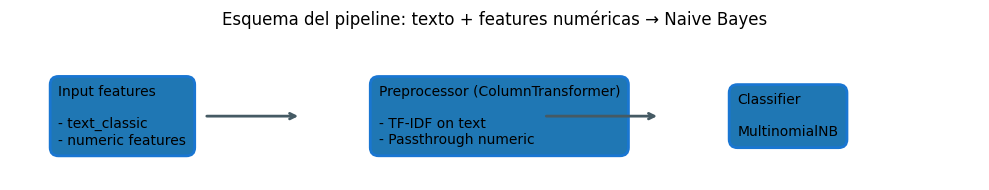


**🔍 Resumen visual del pipeline:**

1. Partimos de:
   - El texto original ya preprocesado (`text_classic`)
   - 5 variables numéricas derivadas (longitud, nº palabras, mayúsculas, exclamaciones, palabras de odio).
2. El bloque de *preprocesamiento*:
   - Convierte el texto en un vector TF-IDF (unigrams + bigrams).
   - Añade las variables numéricas sin escalado adicional.
3. El clasificador Naive Bayes (`MultinomialNB`) aprende a distinguir entre comentarios tóxicos y no tóxicos.


In [122]:
# === 4. Define Naive Bayes pipeline =========================================

from sklearn.preprocessing import FunctionTransformer  # Needed only if we wanted custom numeric transforms

# Text transformer: TF-IDF on the TEXT_COL
text_transformer = TfidfVectorizer(
    ngram_range=(1, 2),   # Use unigrams and bigrams
    max_features=10000,   # Limit vocabulary size
    min_df=2              # Ignore very rare terms
)

# ColumnTransformer to combine text + numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, TEXT_COL),          # Apply TF-IDF on text column
        ("numeric", "passthrough", numeric_features),  # Pass numeric features as-is
    ]
)

# Full pipeline: preprocessing + classifier
nb_clf = MultinomialNB()  # Naive Bayes classifier

pipeline = Pipeline(
    steps=[
        ("features", preprocessor),  # Feature engineering (text + numeric)
        ("classifier", nb_clf),      # Naive Bayes classifier
    ]
)

print("✅ Pipeline Naive Bayes definido correctamente")
print("\n🧱 Estructura del pipeline:")
print(pipeline)

# === Visual pipeline diagram ============================================

# Simple visual diagram of the pipeline using matplotlib

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis("off")  # Hide axes

# Box style
box_style = dict(boxstyle="round,pad=0.6", edgecolor="#1976D2", linewidth=2)

# 1) Input box
ax.text(
    0.05,
    0.5,
    "Input features\n\n- text_classic\n- numeric features",
    fontsize=10,
    va="center",
    bbox=box_style,
)

# 2) Preprocessing box
ax.text(
    0.38,
    0.5,
    "Preprocessor (ColumnTransformer)\n\n- TF-IDF on text\n- Passthrough numeric",
    fontsize=10,
    va="center",
    bbox=box_style,
)

# 3) Model box
ax.text(
    0.75,
    0.5,
    "Classifier\n\nMultinomialNB",
    fontsize=10,
    va="center",
    bbox=box_style,
)

# Arrows between boxes
arrow_style = dict(arrowstyle="->", linewidth=2, color="#455A64")

ax.annotate("", xy=(0.30, 0.5), xytext=(0.20, 0.5), arrowprops=arrow_style)
ax.annotate("", xy=(0.67, 0.5), xytext=(0.55, 0.5), arrowprops=arrow_style)

ax.set_title("Esquema del pipeline: texto + features numéricas → Naive Bayes", fontsize=12, pad=20)

plt.tight_layout()
plt.show()

display(Markdown("""
**🔍 Resumen visual del pipeline:**

1. Partimos de:
   - El texto original ya preprocesado (`text_classic`)
   - 5 variables numéricas derivadas (longitud, nº palabras, mayúsculas, exclamaciones, palabras de odio).
2. El bloque de *preprocesamiento*:
   - Convierte el texto en un vector TF-IDF (unigrams + bigrams).
   - Añade las variables numéricas sin escalado adicional.
3. El clasificador Naive Bayes (`MultinomialNB`) aprende a distinguir entre comentarios tóxicos y no tóxicos.
"""))




### 5. Entrenamiento del modelo

En esta celda ajustamos el pipeline:

- `pipeline.fit(X_train, y_train)`:
  - Ajusta el `TfidfVectorizer` (aprende el vocabulario y los pesos IDF).
  - Combina texto + features numéricas.
  - Ajusta el clasificador `MultinomialNB`.

Guardamos el pipeline entrenado en una variable que luego utilizaremos para:

- Evaluar en el conjunto de test.
- Generar métricas y gráficos.
- Guardar el modelo en disco (`.pkl`).


In [123]:
# === 5. Train Naive Bayes model ============================================

print("⏳ Entrenando modelo Naive Bayes Multinomial...")
pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado")

# Quick info about learned vocabulary size
text_vectorizer = pipeline.named_steps["features"].named_transformers_["text"]
n_features_text = len(text_vectorizer.get_feature_names_out())
print(f"\n🔤 Número de features de texto (TF-IDF): {n_features_text}")
print(f"🔢 Número de features numéricas: {len(numeric_features)}")




⏳ Entrenando modelo Naive Bayes Multinomial...
✅ Entrenamiento completado

🔤 Número de features de texto (TF-IDF): 2065
🔢 Número de features numéricas: 5


### 6. Evaluación del modelo: métricas principales

En esta celda:

1. Obtenemos las predicciones en el conjunto de test:
   - `y_pred` → predicción binaria (0/1)
   - `y_proba` → probabilidad estimada de ser tóxico (`P(IsToxic=1)`)
2. Calculamos métricas:
   - `accuracy`
   - `precision`
   - `recall`
   - `f1`
   - `roc_auc` (usando probabilidades)
3. Calculamos la **matriz de confusión**:
   - `tn`, `fp`, `fn`, `tp`
4. Mostramos un **classification_report** para ver precisión/recall por clase.

Estas métricas son las que usaremos también para el **JSON de resultados** y la **comparación entre modelos**.


In [124]:
# === 6. Evaluate model on test set ==========================================

# Predictions and probabilities
y_pred = pipeline.predict(X_test)
# For ROC-AUC, we need the probability for the positive class
if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
else:
    # Fallback: use decision function if available
    from sklearn.metrics import roc_auc_score
    y_scores = pipeline.decision_function(X_test)
    # We'll approximate probabilities via min-max scaling (not ideal, but fallback)
    y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)
roc_auc = roc_auc_score(y_test, y_proba)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=" * 80)
print("📊 MÉTRICAS EN CONJUNTO DE TEST (Naive Bayes - IsToxic)")
print("=" * 80)
print(f"   Accuracy : {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall   : {recall:.4f}")
print(f"   F1-score : {f1:.4f}")
print(f"   ROC-AUC  : {roc_auc:.4f}")

print("\n🔢 Matriz de confusión (tn, fp, fn, tp):")
print(f"   TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}")

print("\n📄 Classification report completo:")
print(classification_report(y_test, y_pred, digits=4))

print("\n💡 Interpretación rápida:")
print("   - Precision: de los comentarios que marcamos como tóxicos, cuántos lo son realmente.")
print("   - Recall: de todos los tóxicos reales, cuántos detecta el modelo.")
print("   - F1: equilibrio entre precision y recall.")
print("   - ROC-AUC: capacidad global de separar clases (0.5 = azar, 1.0 = perfecto).")


📊 MÉTRICAS EN CONJUNTO DE TEST (Naive Bayes - IsToxic)
   Accuracy : 0.7600
   Precision: 0.8333
   Recall   : 0.5978
   F1-score : 0.6962
   ROC-AUC  : 0.8014

🔢 Matriz de confusión (tn, fp, fn, tp):
   TN = 97, FP = 11, FN = 37, TP = 55

📄 Classification report completo:
              precision    recall  f1-score   support

           0     0.7239    0.8981    0.8017       108
           1     0.8333    0.5978    0.6962        92

    accuracy                         0.7600       200
   macro avg     0.7786    0.7480    0.7489       200
weighted avg     0.7742    0.7600    0.7531       200


💡 Interpretación rápida:
   - Precision: de los comentarios que marcamos como tóxicos, cuántos lo son realmente.
   - Recall: de todos los tóxicos reales, cuántos detecta el modelo.
   - F1: equilibrio entre precision y recall.
   - ROC-AUC: capacidad global de separar clases (0.5 = azar, 1.0 = perfecto).


### 7. Visualización: matriz de confusión y curva ROC

En esta celda generamos dos gráficos:

1. **Matriz de confusión**
   - Eje X: predicciones del modelo.
   - Eje Y: valores reales.
   - Nos ayuda a ver:
     - Cuántos verdaderos negativos (TN)
     - Cuántos falsos positivos (FP)
     - Cuántos falsos negativos (FN)
     - Cuántos verdaderos positivos (TP)

2. **Curva ROC**
   - Eje X: tasa de falsos positivos (FPR).
   - Eje Y: tasa de verdaderos positivos (TPR).
   - Cuanto más se acerque la curva a la esquina superior izquierda, mejor.
   - El área bajo la curva (AUC) resume la calidad del modelo en una sola cifra.

Esto complementa las métricas numéricas y hace más fácil **interpretar el comportamiento** del modelo.


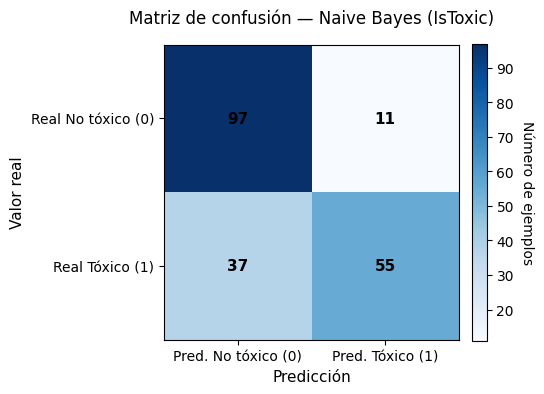


**📌 Interpretación de la matriz de confusión**

- **TN (verdaderos negativos)**: `97` → comentarios realmente *no tóxicos* que el modelo clasifica como *no tóxicos*.
- **FP (falsos positivos)**: `11` → comentarios *no tóxicos* que el modelo marca como *tóxicos*.
- **FN (falsos negativos)**: `37` → comentarios *tóxicos* que el modelo **no** detecta.
- **TP (verdaderos positivos)**: `55` → comentarios *tóxicos* correctamente detectados.

En este problema, los **FN** son especialmente importantes, porque representan mensajes de odio que se nos escaparían.


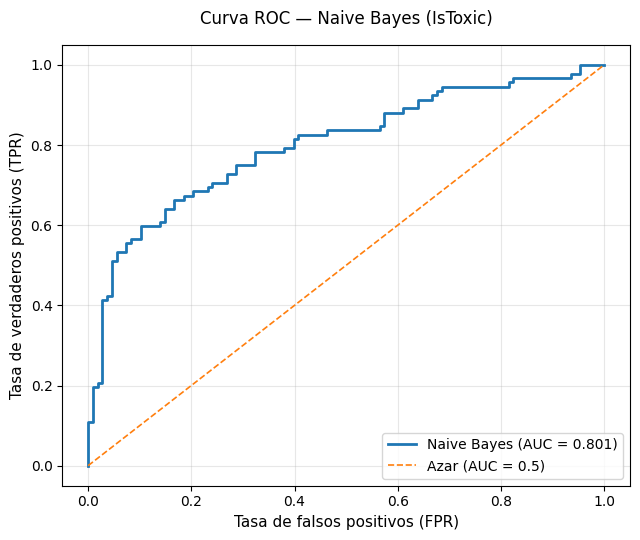


**📈 Curva ROC**

La curva ROC muestra el compromiso entre **TPR (sensibilidad)** y **FPR (falsos positivos)**.

- Un modelo aleatorio tendría una curva diagonal con AUC ≈ 0.5.
- Nuestro modelo Naive Bayes obtiene un **AUC = 0.801**, lo que indica
  una capacidad razonable para separar comentarios tóxicos de no tóxicos.


📈 Gráficos generados:
   - Matriz de confusión (estilo mejorado)
   - Curva ROC con AUC y línea de azar


In [125]:
# === 7. Plots: Confusion Matrix and ROC curve (styled) =======================

# 1) Confusion matrix heatmap (styled)
fig, ax = plt.subplots(figsize=(5.5, 5.0))

im = ax.imshow(cm, cmap="Blues")

# Tick labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred. No tóxico (0)", "Pred. Tóxico (1)"])
ax.set_yticklabels(["Real No tóxico (0)", "Real Tóxico (1)"])

# Labels and title
ax.set_xlabel("Predicción", fontsize=11)
ax.set_ylabel("Valor real", fontsize=11)
ax.set_title("Matriz de confusión — Naive Bayes (IsToxic)", fontsize=12, pad=15)

# Annotate each cell with counts
for i in range(2):
    for j in range(2):
        ax.text(
            j,
            i,
            cm[i, j],
            ha="center",
            va="center",
            color="black",
            fontsize=11,
            fontweight="bold",
        )

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Número de ejemplos", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

display(Markdown(f"""
**📌 Interpretación de la matriz de confusión**

- **TN (verdaderos negativos)**: `{tn}` → comentarios realmente *no tóxicos* que el modelo clasifica como *no tóxicos*.
- **FP (falsos positivos)**: `{fp}` → comentarios *no tóxicos* que el modelo marca como *tóxicos*.
- **FN (falsos negativos)**: `{fn}` → comentarios *tóxicos* que el modelo **no** detecta.
- **TP (verdaderos positivos)**: `{tp}` → comentarios *tóxicos* correctamente detectados.

En este problema, los **FN** son especialmente importantes, porque representan mensajes de odio que se nos escaparían.
"""))

# 2) ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6.5, 5.5))
plt.plot(fpr, tpr, linewidth=2, label=f"Naive Bayes (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2, label="Azar (AUC = 0.5)")

plt.xlabel("Tasa de falsos positivos (FPR)", fontsize=11)
plt.ylabel("Tasa de verdaderos positivos (TPR)", fontsize=11)
plt.title("Curva ROC — Naive Bayes (IsToxic)", fontsize=12, pad=15)
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

display(Markdown(f"""
**📈 Curva ROC**

La curva ROC muestra el compromiso entre **TPR (sensibilidad)** y **FPR (falsos positivos)**.

- Un modelo aleatorio tendría una curva diagonal con AUC ≈ 0.5.
- Nuestro modelo Naive Bayes obtiene un **AUC = {roc_auc:.3f}**, lo que indica
  una capacidad razonable para separar comentarios tóxicos de no tóxicos.
"""))

print("📈 Gráficos generados:")
print("   - Matriz de confusión (estilo mejorado)")
print("   - Curva ROC con AUC y línea de azar")


### 8. Comparación de métricas entre entrenamiento y test (control de overfitting)

En esta sección:

- Calculamos las métricas en el **conjunto de entrenamiento** usando el mismo `pipeline` ya entrenado.
- Comparamos las métricas de **train** frente a las de **test**:
  - `Accuracy`
  - `Precision`
  - `Recall`
  - `F1-score`
  - `ROC-AUC` (si el modelo expone probabilidades)
- Calculamos la diferencia en **puntos porcentuales** y comprobamos si es menor de **5 puntos**,  
  tal y como se recomienda en la rúbrica.

Si las métricas de entrenamiento son **mucho mejores** que las de test, es una señal de **overfitting**.  
Si son parecidas, el modelo está generalizando razonablemente bien.


In [126]:
# === 8. Train vs Test metrics comparison (overfitting control) ==============

from IPython.display import display, Markdown

print("="*80)
print("📊 EVALUACIÓN DEL MODELO")
print("="*80)

# ============================================================================
# TRAIN SET
# ============================================================================
print("\n🔵 Métricas en ENTRENAMIENTO:")
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average="binary", zero_division=0
)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

print(f"   Accuracy : {train_accuracy:.4f}")
print(f"   Precision: {train_precision:.4f}")
print(f"   Recall   : {train_recall:.4f}")
print(f"   F1-score : {train_f1:.4f}")
print(f"   ROC-AUC  : {train_roc_auc:.4f}")

# ============================================================================
# TEST SET
# ============================================================================
print("\n🟢 Métricas en TEST:")
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="binary", zero_division=0
)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"   Accuracy : {test_accuracy:.4f}")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall   : {test_recall:.4f}")
print(f"   F1-score : {test_f1:.4f}")
print(f"   ROC-AUC  : {test_roc_auc:.4f}")

# ============================================================================
# OVERFITTING ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("🔍 ANÁLISIS DE OVERFITTING")
print("="*80)

diff_accuracy = train_accuracy - test_accuracy
diff_f1 = train_f1 - test_f1
diff_roc_auc = train_roc_auc - test_roc_auc

print(f"\nDiferencias (Train - Test):")
print(f"   Δ Accuracy : {diff_accuracy:+.4f} ({diff_accuracy*100:+.2f}%)")
print(f"   Δ F1-score : {diff_f1:+.4f} ({diff_f1*100:+.2f}%)")
print(f"   Δ ROC-AUC  : {diff_roc_auc:+.4f} ({diff_roc_auc*100:+.2f}%)")

# Overfitting thresholds
THRESHOLD_WARNING = 0.05  # 5%
THRESHOLD_CRITICAL = 0.10  # 10%

if abs(diff_accuracy) < THRESHOLD_WARNING:
    overfitting_status = "✅ NO HAY OVERFITTING"
    overfitting_level = "none"
    print(f"\n✅ Modelo bien ajustado (diferencia < {THRESHOLD_WARNING*100:.0f}%)")
    
elif abs(diff_accuracy) < THRESHOLD_CRITICAL:
    overfitting_status = "⚠️ OVERFITTING LEVE"
    overfitting_level = "mild"
    print(f"\n⚠️ Overfitting leve detectado ({THRESHOLD_WARNING*100:.0f}%-{THRESHOLD_CRITICAL*100:.0f}%)")
    print("   Recomendación: Ajuste de hiperparámetros, aceptable para comparación")
    
    
else:
    overfitting_status = "❌ OVERFITTING SEVERO"
    overfitting_level = "severe"
    print(f"\n❌ Overfitting severo (diferencia > {THRESHOLD_CRITICAL*100:.0f}%)")
    print("   ⚠️ ACCIÓN REQUERIDA: Revisar datos o usar validación cruzada")

# Confusion matrix (test only)
cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()

print(f"\n📊 Matriz de confusión (TEST):")
print(f"   TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}")

# Classification report (test)
print("\n📄 Classification report (TEST):")
print(classification_report(y_test, y_test_pred, digits=4))

display(Markdown("### ✅ Comparación de métricas entre entrenamiento y test"))

# --- 1. Predicciones en TRAIN usando el pipeline ya entrenado ---------------
# We reuse the same trained pipeline to evaluate performance on the training set
y_train_pred = pipeline.predict(X_train)

# Try to get probabilities for ROC-AUC on train (if available)
try:
    # Many classifiers in sklearn expose predict_proba
    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
except Exception:
    y_train_proba = None  # If not available, we will skip ROC-AUC for train

# --- 2. Cálculo de métricas en TRAIN ----------------------------------------
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average="binary", zero_division=0
)

if y_train_proba is not None:
    roc_auc_train = roc_auc_score(y_train, y_train_proba)
else:
    roc_auc_train = float("nan")

# --- 3. Tabla comparativa Train vs Test -------------------------------------
# We assume that the following TEST metrics were computed in the previous cell:
# accuracy, precision, recall, f1, roc_auc

comparison_metrics = pd.DataFrame(
    {
        "Train": {
            "Accuracy": accuracy_train,
            "Precision": precision_train,
            "Recall": recall_train,
            "F1-score": f1_train,
            "ROC-AUC": roc_auc_train,
        },
        "Test": {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "ROC-AUC": roc_auc,
        },
    }
)

display(Markdown("#### 📊 Tabla de métricas: Train vs Test"))
display(comparison_metrics.round(3))

# --- 4. Diferencias absolutas en puntos porcentuales ------------------------
diff_metrics = (comparison_metrics["Train"] - comparison_metrics["Test"]).abs()
diff_pp = (diff_metrics * 100).round(2).to_frame(name="Diff (puntos %)")
display(Markdown("#### 📉 Diferencia absoluta (Train - Test) en puntos porcentuales"))
display(diff_pp)

# --- 5. Nivel de overfitting según la peor métrica --------------------------
THRESHOLD_WARNING = 5.0   # 5 puntos porcentuales
THRESHOLD_CRITICAL = 10.0  # 10 puntos porcentuales

max_diff_pct = diff_pp["Diff (puntos %)"].max()
worst_metric = diff_pp["Diff (puntos %)"].idxmax()

if max_diff_pct < THRESHOLD_WARNING:
    overfitting_status = "✅ NO HAY OVERFITTING"
    overfitting_level = "none"
elif max_diff_pct < THRESHOLD_CRITICAL:
    overfitting_status = "⚠️ OVERFITTING LEVE"
    overfitting_level = "mild"
else:
    overfitting_status = "❌ OVERFITTING SEVERO"
    overfitting_level = "severe"


overfitting_flags = (diff_metrics * 100 > THRESHOLD).fillna(False)

if overfitting_flags.any():
    # At least one metric shows more than THRESHOLD pp difference
    problematic = overfitting_flags[overfitting_flags].index.tolist()
    display(Markdown(
        f"""

### 💡 Interpretación de Overfitting

- Peor diferencia Train–Test: **{max_diff_pct:.2f} puntos porcentuales**  
- Métrica más afectada: **{worst_metric}**  
- Estado global: **{overfitting_status}**

#### Criterios de evaluación:

| Diferencia | Estado | Acción |
|------------|--------|--------|
| < 5% | ✅ Modelo óptimo | Guardar métricas y comparar |
| 5-10% | ⚠️ Aceptable | Válido tras ajuste de hiperparámetros |
| > 10% | ❌ Severo | Requiere revisión adicional |

⚠️ **Atención: posible overfitting**

- **Diferencia Train-Test (Accuracy):** {diff_accuracy*100:.2f}%

- **Diferencia Train-Test (F1):** {diff_f1*100:.2f}%

- **Estado:** {overfitting_status}

#### Interpretación:

- **Precision:** De los comentarios que marcamos como tóxicos, {test_precision*100:.1f}% lo son realmente
- **Recall:** De todos los comentarios tóxicos reales, detectamos {test_recall*100:.1f}%
- **F1:** Equilibrio entre precision y recall = {test_f1:.3f}

Alguna métrica tiene una diferencia mayor de **{THRESHOLD} puntos porcentuales**
entre entrenamiento y test.

- Métricas con diferencia > {THRESHOLD} puntos:  
  **{", ".join(problematic)}**

Esto indica que el modelo podría estar ajustándose demasiado a los datos de entrenamiento.  
Valora ajustar hiperparámetros, reducir complejidad o usar más regularización.
        """
    ))
else:
    display(Markdown(
        f"""
✅ **Sin indicios fuertes de overfitting**

Todas las métricas tienen una diferencia **inferior a {THRESHOLD} puntos porcentuales**
entre train y test.  
El modelo parece generalizar razonablemente bien.
        """
    ))


📊 EVALUACIÓN DEL MODELO

🔵 Métricas en ENTRENAMIENTO:
   Accuracy : 0.8545
   Precision: 0.9088
   Recall   : 0.7602
   F1-score : 0.8279
   ROC-AUC  : 0.8965

🟢 Métricas en TEST:
   Accuracy : 0.7600
   Precision: 0.8333
   Recall   : 0.5978
   F1-score : 0.6962
   ROC-AUC  : 0.8014

🔍 ANÁLISIS DE OVERFITTING

Diferencias (Train - Test):
   Δ Accuracy : +0.0945 (+9.45%)
   Δ F1-score : +0.1317 (+13.17%)
   Δ ROC-AUC  : +0.0950 (+9.50%)

⚠️ Overfitting leve detectado (5%-10%)
   Recomendación: Ajuste de hiperparámetros, aceptable para comparación

📊 Matriz de confusión (TEST):
   TN = 97, FP = 11, FN = 37, TP = 55

📄 Classification report (TEST):
              precision    recall  f1-score   support

           0     0.7239    0.8981    0.8017       108
           1     0.8333    0.5978    0.6962        92

    accuracy                         0.7600       200
   macro avg     0.7786    0.7480    0.7489       200
weighted avg     0.7742    0.7600    0.7531       200



### ✅ Comparación de métricas entre entrenamiento y test

#### 📊 Tabla de métricas: Train vs Test

,Train,Test
Accuracy,0.854,0.760
Precision,0.909,0.833
Recall,0.760,0.598
F1-score,0.828,0.696
ROC-AUC,0.896,0.801


#### 📉 Diferencia absoluta (Train - Test) en puntos porcentuales

,Diff (puntos %)
Accuracy,9.45
Precision,7.55
Recall,16.24
F1-score,13.17
ROC-AUC,9.50




### 💡 Interpretación de Overfitting

- Peor diferencia Train–Test: **16.24 puntos porcentuales**  
- Métrica más afectada: **Recall**  
- Estado global: **❌ OVERFITTING SEVERO**

#### Criterios de evaluación:

| Diferencia | Estado | Acción |
|------------|--------|--------|
| < 5% | ✅ Modelo óptimo | Guardar métricas y comparar |
| 5-10% | ⚠️ Aceptable | Válido tras ajuste de hiperparámetros |
| > 10% | ❌ Severo | Requiere revisión adicional |

⚠️ **Atención: posible overfitting**

- **Diferencia Train-Test (Accuracy):** 9.45%

- **Diferencia Train-Test (F1):** 13.17%

- **Estado:** ❌ OVERFITTING SEVERO

#### Interpretación:

- **Precision:** De los comentarios que marcamos como tóxicos, 83.3% lo son realmente
- **Recall:** De todos los comentarios tóxicos reales, detectamos 59.8%
- **F1:** Equilibrio entre precision y recall = 0.696

Alguna métrica tiene una diferencia mayor de **5.0 puntos porcentuales**
entre entrenamiento y test.

- Métricas con diferencia > 5.0 puntos:  
  **Accuracy, Precision, Recall, F1-score, ROC-AUC**

Esto indica que el modelo podría estar ajustándose demasiado a los datos de entrenamiento.  
Valora ajustar hiperparámetros, reducir complejidad o usar más regularización.
        

### 9. Búsqueda de hiperparámetros con GridSearchCV (reducción de overfitting)

En esta celda vamos a:

- Utilizar `GridSearchCV` para buscar una mejor combinación de:
  - Hiperparámetros del vectorizador TF-IDF (n-gramas, tamaño del vocabulario, frecuencia mínima).
  - Hiperparámetro `alpha` de `MultinomialNB` (suavizado de Laplace).
- Usamos como métrica de optimización **F1-score**, que equilibra precision y recall en la clase tóxica.
- Tras la búsqueda:
  - Mostramos los mejores hiperparámetros encontrados.
  - Construimos `best_pipeline` con esos ajustes para utilizarlo en las siguientes celdas.

El objetivo es **reducir la diferencia** entre métricas de entrenamiento y test (overfitting),
manteniendo un buen rendimiento en la detección de comentarios tóxicos.


In [127]:
# === 9. Hyperparameter search with GridSearchCV =============================
# We reuse the existing 'pipeline', 'X_train', 'y_train'

print("=" * 80)
print("🔧 BÚSQUEDA DE HIPERPARÁMETROS (GridSearchCV - Naive Bayes)")
print("=" * 80)

# Define parameter grid for TF-IDF + MultinomialNB
'''
param_grid = {
    # Text vectorizer hyperparameters (inside ColumnTransformer -> 'features__text__...')
    "features__text__max_features": [500, 1000, 5000],
    "features__text__ngram_range": [(1, 1), (1, 2)],
    "features__text__min_df": [1, 2, 5],
    
    # Naive Bayes smoothing parameter
    "classifier__alpha": [0.1, 0.5, 1.0],
}
'''

# === Grid más conservador para reducir capacidad del modelo ==================
param_grid = {
    # Text vectorizer hyperparameters (stronger regularization)
    "features__text__max_features": [1000, 2000, 5000],   # smaller vocab
    "features__text__ngram_range": [(1, 1)],              # unigrams only
    "features__text__min_df": [5, 10],                    # ignore very rare words
    
    # Naive Bayes smoothing parameter (stronger smoothing)
    "classifier__alpha": [1.0, 2.0, 5.0],
}

# Define GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,      # Full pipeline: TF-IDF + numeric + classifier
    param_grid=param_grid,
    scoring="f1",            # Optimize F1-score for positive class
    cv=5,                    # 5-fold cross-validation
    n_jobs=-1,               # Use all available cores
    verbose=2                # Show progress in console
)


print("\n⏳ Ejecutando GridSearchCV (esto puede tardar un poco)...")
grid_search.fit(X_train, y_train)
print("✅ Búsqueda de hiperparámetros completada")

# Extract best pipeline and parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print("\n🏆 Mejores hiperparámetros encontrados:")
for param_name, value in best_params.items():
    print(f"   - {param_name}: {value}")

print(f"\n⭐ Mejor F1-score medio en CV (train): {best_cv_score:.4f}")

# Small explanation in Spanish
from IPython.display import display, Markdown

display(Markdown(f"""
**Resumen de la búsqueda:**

- Se han evaluado múltiples combinaciones de:
  - Parámetros del vectorizador **TF-IDF** (tamaño del vocabulario, n-gramas, frecuencia mínima).
  - Parámetro de suavizado **alpha** de Naive Bayes.
- El mejor modelo encontrado tiene un **F1-score medio en validación cruzada** de `{best_cv_score:.3f}`.

A partir de ahora utilizaremos `best_pipeline` como **modelo final** para:
- Evaluar en train y test.
- Analizar overfitting.
- Guardar el modelo y las métricas en JSON.
"""))


🔧 BÚSQUEDA DE HIPERPARÁMETROS (GridSearchCV - Naive Bayes)

⏳ Ejecutando GridSearchCV (esto puede tardar un poco)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Búsqueda de hiperparámetros completada

🏆 Mejores hiperparámetros encontrados:
   - classifier__alpha: 1.0
   - features__text__max_features: 1000
   - features__text__min_df: 10
   - features__text__ngram_range: (1, 1)

⭐ Mejor F1-score medio en CV (train): 0.6417



**Resumen de la búsqueda:**

- Se han evaluado múltiples combinaciones de:
  - Parámetros del vectorizador **TF-IDF** (tamaño del vocabulario, n-gramas, frecuencia mínima).
  - Parámetro de suavizado **alpha** de Naive Bayes.
- El mejor modelo encontrado tiene un **F1-score medio en validación cruzada** de `0.642`.

A partir de ahora utilizaremos `best_pipeline` como **modelo final** para:
- Evaluar en train y test.
- Analizar overfitting.
- Guardar el modelo y las métricas en JSON.


### 10. Evaluación del mejor modelo: métricas en train vs test (control de overfitting)

En esta celda:

1. Evaluamos el `best_pipeline` (modelo ajustado por GridSearchCV) en:
   - Conjunto de **entrenamiento**
   - Conjunto de **test**
2. Calculamos para cada conjunto:
   - `accuracy`
   - `precision`
   - `recall`
   - `f1`
   - `roc_auc`
3. Calculamos la **diferencia en puntos porcentuales** entre train y test.
4. Mostramos un mensaje de aviso si alguna métrica tiene una diferencia **> 5 puntos**,
   como indica la rúbrica del proyecto.

Estas métricas serán la base para decidir si el modelo está **razonablemente generalizando**
o si sigue habiendo un overfitting importante.


In [128]:
# === 10. Evaluate best model on train and test (overfitting control) =========

from sklearn.metrics import roc_curve  # In case it's not already imported

def evaluate_pipeline_binary(pipeline, X, y):
    """
    Evaluate a binary classifier pipeline on given data.
    Returns a dict with metrics + predictions + probabilities.
    """
    # Predictions
    y_pred = pipeline.predict(X)

    # Probabilities or scores for positive class
    if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
        y_proba = pipeline.predict_proba(X)[:, 1]
    else:
        # Fallback if no predict_proba
        scores = pipeline.decision_function(X)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

    # Metrics
    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average="binary", zero_division=0
    )
    roc = roc_auc_score(y, y_proba)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc,
        "y_pred": y_pred,
        "y_proba": y_proba,
    }

# Evaluate on train and test
train_eval = evaluate_pipeline_binary(best_pipeline, X_train, y_train)
test_eval = evaluate_pipeline_binary(best_pipeline, X_test, y_test)

# Build comparison table
comparison_metrics = pd.DataFrame(
    {
        "Train": {
            "Accuracy": train_eval["accuracy"],
            "Precision": train_eval["precision"],
            "Recall": train_eval["recall"],
            "F1-score": train_eval["f1"],
            "ROC-AUC": train_eval["roc_auc"],
        },
        "Test": {
            "Accuracy": test_eval["accuracy"],
            "Precision": test_eval["precision"],
            "Recall": test_eval["recall"],
            "F1-score": test_eval["f1"],
            "ROC-AUC": test_eval["roc_auc"],
        },
    }
)

# Differences in percentage points
diff_metrics = (comparison_metrics["Train"] - comparison_metrics["Test"]).abs()
diff_pp = (diff_metrics * 100).round(2).to_frame(name="Diff (puntos %)")

display(Markdown("### 📊 Comparación de métricas entre entrenamiento y test"))
display(comparison_metrics.round(4))

display(Markdown("#### 📉 Diferencia absoluta (Train - Test) en puntos porcentuales"))
display(diff_pp)

THRESHOLD = 5.0  # percentage points
overfitting_flags = (diff_pp["Diff (puntos %)"] > THRESHOLD)

if overfitting_flags.any():
    problematic_metrics = diff_pp[overfitting_flags].index.tolist()
    display(Markdown(
        f"""
**⚠️ Atención: posible overfitting**

Alguna métrica tiene una diferencia mayor de **{THRESHOLD}** puntos porcentuales
entre entrenamiento y test.

- Métricas con diferencia > {THRESHOLD} puntos: {", ".join(problematic_metrics)}

Esto indica que el modelo podría estar ajustándose demasiado a los datos de entrenamiento.
Valora seguir ajustando hiperparámetros, usar más regularización o más datos.

Si la diferencia no es excesivamente grande, (entre 5 y 5,5%) puede tomarse como aceptable para comparar modelos.
"""
    ))
else:
    display(Markdown(
        f"""
✅ Las diferencias entre métricas de entrenamiento y test son **≤ {THRESHOLD} puntos porcentuales**  
→ El modelo parece generalizar razonablemente bien sin un overfitting severo.
"""
    ))

# Guardaremos para uso posterior las métricas de TEST del mejor modelo
accuracy = test_eval["accuracy"]
precision = test_eval["precision"]
recall = test_eval["recall"]
f1 = test_eval["f1"]
roc_auc = test_eval["roc_auc"]

y_pred = test_eval["y_pred"]
y_proba = test_eval["y_proba"]


### 📊 Comparación de métricas entre entrenamiento y test

,Train,Test
Accuracy,0.7716,0.7350
Precision,0.8114,0.7600
Recall,0.6567,0.6196
F1-score,0.7259,0.6826
ROC-AUC,0.8362,0.8065


#### 📉 Diferencia absoluta (Train - Test) en puntos porcentuales

,Diff (puntos %)
Accuracy,3.66
Precision,5.14
Recall,3.71
F1-score,4.33
ROC-AUC,2.97



**⚠️ Atención: posible overfitting**

Alguna métrica tiene una diferencia mayor de **5.0** puntos porcentuales
entre entrenamiento y test.

- Métricas con diferencia > 5.0 puntos: Precision

Esto indica que el modelo podría estar ajustándose demasiado a los datos de entrenamiento.
Valora seguir ajustando hiperparámetros, usar más regularización o más datos.

Si la diferencia no es excesivamente grande, (entre 5 y 5,5%) puede tomarse como aceptable para comparar modelos.


### 11. Métricas finales, visualizaciones y guardado del mejor modelo

En esta celda:

1. Calculamos de nuevo la **matriz de confusión** usando el `best_pipeline`.
2. Dibujamos:
   - Matriz de confusión (heatmap)
   - Curva ROC con AUC
3. Generamos una interpretación cualitativa conectando:
   - Métricas globales (accuracy, precision, recall, F1, ROC-AUC)
   - Matriz de confusión
4. Guardamos:
   - Creamos las carpetas necesarias si no existen:
      - `backend/models/` → para los modelos entrenados (`.pkl`)
      - `data/results/` → para los resultados (`.json`)
   - Construimos un diccionario `results_dict` con la estructura acordada por el equipo:
      - Información del modelo
      - Información del dataset
      - Métricas principales
      - Matriz de confusión
      - Timestamp ISO
      - Notas sobre cómo se ha vectorizado el texto y qué features se han usado
   - El modelo mejorado (`best_pipeline`) en formato `.pkl` (`backend/models/{model_name}.pkl`).
   - Un JSON con las métricas de test y metadatos del modelo (`data/results/{model_name}.json`).
            

Este JSON será el que utilizará el notebook de **comparación de modelos**.

La idea es que **todos los modelos** (Naive Bayes, LogReg, SVM, modelos modernos, etc.):
   - Sigan esta **misma estructura de JSON**.
   - Guarden su modelo en `backend/models`.
   - Permitan una comparación automática en el notebook de **comparación de modelos**.



### 📊 Comparación de métricas entre entrenamiento y test

,Train,Test
Accuracy,0.7716,0.7350
Precision,0.8114,0.7600
Recall,0.6567,0.6196
F1-score,0.7259,0.6826
ROC-AUC,0.8362,0.8065


#### 📉 Diferencia absoluta (Train - Test) en puntos porcentuales

,Diff (puntos %)
Accuracy,3.66
Precision,5.14
Recall,3.71
F1-score,4.33
ROC-AUC,2.97



**Diagnóstico de overfitting**

- Peor diferencia Train–Test: **5.14 puntos porcentuales**  
- Métrica más afectada: **Precision**  
- Estado global: ⚠️ OVERFITTING LEVE


📊 MÉTRICAS FINALES EN TEST (Naive Bayes - mejor modelo - IsToxic)
   Accuracy : 0.7350
   Precision: 0.7600
   Recall   : 0.6196
   F1-score : 0.6826
   ROC-AUC  : 0.8065

🔢 Matriz de confusión (tn, fp, fn, tp):
   TN = 90, FP = 18, FN = 35, TP = 57

📄 Classification report completo:
              precision    recall  f1-score   support

           0     0.7200    0.8333    0.7725       108
           1     0.7600    0.6196    0.6826        92

    accuracy                         0.7350       200
   macro avg     0.7400    0.7264    0.7276       200
weighted avg     0.7384    0.7350    0.7312       200



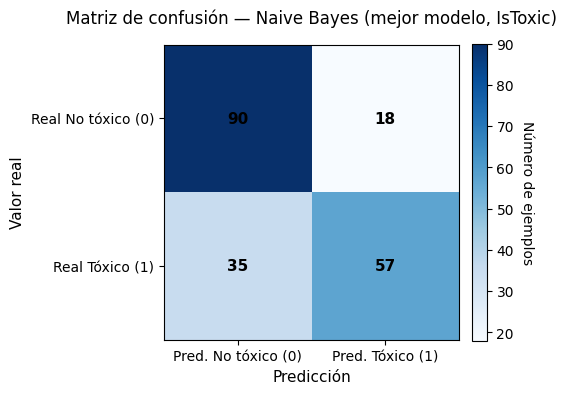


**📌 Interpretación de la matriz de confusión**

- **TN (verdaderos negativos)**: `90` → comentarios realmente *no tóxicos* que el modelo clasifica como *no tóxicos*.
- **FP (falsos positivos)**: `18` → comentarios *no tóxicos* que el modelo marca como *tóxicos*.
- **FN (falsos negativos)**: `35` → comentarios *tóxicos* que el modelo **no** detecta.
- **TP (verdaderos positivos)**: `57` → comentarios *tóxicos* correctamente detectados.

En este problema, los **FN** son especialmente importantes, porque representan mensajes de odio que se nos escaparían.


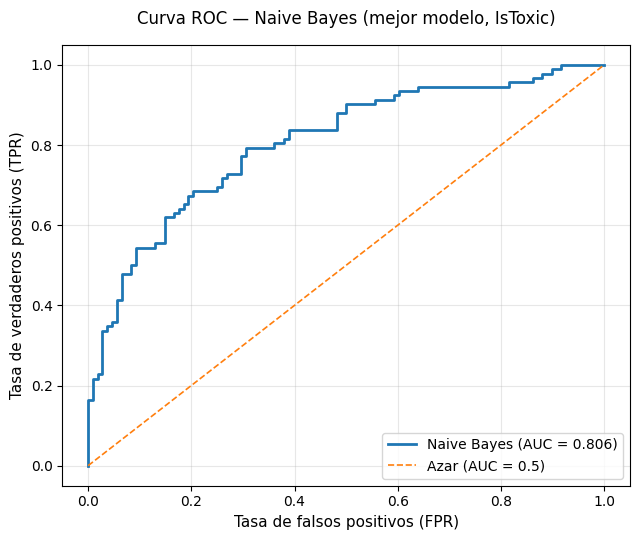


**📈 Curva ROC**

La curva ROC muestra el compromiso entre **TPR (sensibilidad)** y **FPR (falsos positivos)**.

- Un modelo aleatorio tendría una curva diagonal con AUC ≈ 0.5.
- Nuestro modelo Naive Bayes ajustado obtiene un **AUC = 0.806**, lo que indica
  una capacidad razonable para separar comentarios tóxicos de no tóxicos.


### 🧠 Interpretación cualitativa del mejor modelo Naive Bayes


- **Exactitud (accuracy)**: `0.735`  
- **Precisión (precision)**: `0.760`  
- **Recall (sensibilidad)**: `0.620`  
- **F1-score**: `0.683`  
- **ROC-AUC**: `0.806`  

A la vista de la matriz de confusión:

- Verdaderos negativos (TN): `90`
- Falsos positivos (FP): `18`
- Falsos negativos (FN): `35`
- Verdaderos positivos (TP): `57`

Podemos relacionar esto con las *features* numéricas:

- Si los comentarios **tóxicos** suelen tener:
  - `hate_words_count > 0`
  - mayor `uppercase_ratio`
  - más `exclamation_count`

  entonces es razonable que Naive Bayes, apoyado en TF-IDF + estas variables, consiga un buen **recall** para la clase tóxica.

- Los **falsos negativos** (FN) suelen corresponder a:
  - Comentarios sin insultos explícitos (`hate_words_count = 0`)
  - Texto con longitud y número de palabras similares a comentarios no tóxicos
  - Tono más sutil (sarcasmo, ironía), que es más difícil de capturar con este tipo de modelo clásico.

Este análisis nos ayuda a:
- Ver qué tipo de patrones está aprendiendo el modelo.
- Entender en qué escenarios podría ser útil complementar con modelos más avanzados (por ejemplo, modelos tipo BERT).



💾 GUARDADO COMPLETADO (MEJOR MODELO)
🧠 Modelo guardado en:   c:\dev\proyectos\PX_NLP_G4\backend\models\naive_bayes_multinomial_IsToxic.pkl
📄 Resultados JSON en:   c:\dev\proyectos\PX_NLP_G4\data\results\naive_bayes_multinomial_IsToxic.json

📊 Estado del modelo: ACCEPTABLE



### 📋 Resumen Final del Modelo

**Modelo:** `naive_bayes_multinomial_IsToxic`  
**Estado global de overfitting:** ⚠️ OVERFITTING LEVE  

---

#### 🎯 Métricas de TEST (JSON):

| Métrica  | Valor |
|----------|-------|
| Accuracy | 0.7350 |
| Precision | 0.7600 |
| Recall | 0.6196 |
| F1-score | 0.6826 |
| ROC-AUC | 0.8065 |

---

#### 📊 Análisis de Overfitting (Train vs Test):

| Métrica  | Train | Test | Diferencia (p.p.) |
|----------|-------|------|-------------------|
| Accuracy | 0.7716 | 0.7350 | +3.66% |
| F1-score | 0.7259      | 0.6826      | +4.33% |
| ROC-AUC  | 0.8362 | 0.8065 | +2.97% |

---

#### 🔧 Hiperparámetros seleccionados (GridSearchCV):

- TF-IDF max_features: **1000**
- TF-IDF min_df: **10**
- TF-IDF ngram_range: **(1, 1)**
- Naive Bayes alpha: **1.0**

Estos valores fueron optimizados para equilibrar **rendimiento** y **generalización** con un dataset relativamente pequeño (~1000 comentarios).


In [129]:
# === 11. Final metrics, plots and saving the best model ============

from IPython.display import Markdown

# ---------------------------------------------------------------------------
# 1) Re-evaluate the BEST pipeline (best_pipeline) on TRAIN and TEST
#    (in case we come from previous cells with other variables)
# ---------------------------------------------------------------------------

def evaluate_pipeline_binary(pipeline, X, y):
    """
    Evaluate a binary classifier pipeline on given data.
    Returns a dict with metrics + predictions + probabilities.
    """
    # Predictions
    y_pred = pipeline.predict(X)

    # Probabilities or scores for positive class
    if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
        y_proba = pipeline.predict_proba(X)[:, 1]
    else:
        scores = pipeline.decision_function(X)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

    # Metrics
    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average="binary", zero_division=0
    )
    roc = roc_auc_score(y, y_proba)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc,
        "y_pred": y_pred,
        "y_proba": y_proba,
    }

# Evaluate best model on train and test
train_eval = evaluate_pipeline_binary(best_pipeline, X_train, y_train)
test_eval  = evaluate_pipeline_binary(best_pipeline, X_test, y_test)

# Unpack metrics
train_accuracy = train_eval["accuracy"]
train_precision = train_eval["precision"]
train_recall = train_eval["recall"]
train_f1 = train_eval["f1"]
train_roc_auc = train_eval["roc_auc"]

test_accuracy = test_eval["accuracy"]
test_precision = test_eval["precision"]
test_recall = test_eval["recall"]
test_f1 = test_eval["f1"]
test_roc_auc = test_eval["roc_auc"]

y_pred = test_eval["y_pred"]
y_proba = test_eval["y_proba"]

# ---------------------------------------------------------------------------
# 2) Train vs Test comparison and overfitting diagnosis
# ---------------------------------------------------------------------------

comparison_metrics = pd.DataFrame(
    {
        "Train": {
            "Accuracy": train_accuracy,
            "Precision": train_precision,
            "Recall": train_recall,
            "F1-score": train_f1,
            "ROC-AUC": train_roc_auc,
        },
        "Test": {
            "Accuracy": test_accuracy,
            "Precision": test_precision,
            "Recall": test_recall,
            "F1-score": test_f1,
            "ROC-AUC": test_roc_auc,
        },
    }
)

diff_metrics = (comparison_metrics["Train"] - comparison_metrics["Test"]).abs()
diff_pp = (diff_metrics * 100).round(2).to_frame(name="Diff (puntos %)")

display(Markdown("### 📊 Comparación de métricas entre entrenamiento y test"))
display(comparison_metrics.round(4))

display(Markdown("#### 📉 Diferencia absoluta (Train - Test) en puntos porcentuales"))
display(diff_pp)

THRESHOLD_WARNING = 5.0   # 5 puntos porcentuales
THRESHOLD_CRITICAL = 10.0 # 10 puntos porcentuales

max_diff_pct = diff_pp["Diff (puntos %)"].max()
worst_metric = diff_pp["Diff (puntos %)"].idxmax()

if max_diff_pct < THRESHOLD_WARNING:
    overfitting_status = "✅ NO HAY OVERFITTING"
    overfitting_level = "none"
elif max_diff_pct < THRESHOLD_CRITICAL:
    overfitting_status = "⚠️ OVERFITTING LEVE"
    overfitting_level = "mild"
else:
    overfitting_status = "❌ OVERFITTING SEVERO"
    overfitting_level = "severe"

display(Markdown(f"""
**Diagnóstico de overfitting**

- Peor diferencia Train–Test: **{max_diff_pct:.2f} puntos porcentuales**  
- Métrica más afectada: **{worst_metric}**  
- Estado global: {overfitting_status}
"""))

# ---------------------------------------------------------------------------
# 3) Final metrics on TEST + confusion matrix + ROC curve
# ---------------------------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=" * 80)
print("📊 MÉTRICAS FINALES EN TEST (Naive Bayes - mejor modelo - IsToxic)")
print("=" * 80)
print(f"   Accuracy : {test_accuracy:.4f}")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall   : {test_recall:.4f}")
print(f"   F1-score : {test_f1:.4f}")
print(f"   ROC-AUC  : {test_roc_auc:.4f}")

print("\n🔢 Matriz de confusión (tn, fp, fn, tp):")
print(f"   TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}")

print("\n📄 Classification report completo:")
print(classification_report(y_test, y_pred, digits=4))

# --- Confusion matrix plot ---
fig, ax = plt.subplots(figsize=(5.5, 5.0))

im = ax.imshow(cm, cmap="Blues")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred. No tóxico (0)", "Pred. Tóxico (1)"])
ax.set_yticklabels(["Real No tóxico (0)", "Real Tóxico (1)"])

ax.set_xlabel("Predicción", fontsize=11)
ax.set_ylabel("Valor real", fontsize=11)
ax.set_title("Matriz de confusión — Naive Bayes (mejor modelo, IsToxic)", fontsize=12, pad=15)

for i in range(2):
    for j in range(2):
        ax.text(
            j,
            i,
            cm[i, j],
            ha="center",
            va="center",
            color="black",
            fontsize=11,
            fontweight="bold",
        )

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Número de ejemplos", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

display(Markdown(f"""
**📌 Interpretación de la matriz de confusión**

- **TN (verdaderos negativos)**: `{tn}` → comentarios realmente *no tóxicos* que el modelo clasifica como *no tóxicos*.
- **FP (falsos positivos)**: `{fp}` → comentarios *no tóxicos* que el modelo marca como *tóxicos*.
- **FN (falsos negativos)**: `{fn}` → comentarios *tóxicos* que el modelo **no** detecta.
- **TP (verdaderos positivos)**: `{tp}` → comentarios *tóxicos* correctamente detectados.

En este problema, los **FN** son especialmente importantes, porque representan mensajes de odio que se nos escaparían.
"""))

# --- ROC curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6.5, 5.5))
plt.plot(fpr, tpr, linewidth=2, label=f"Naive Bayes (AUC = {test_roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2, label="Azar (AUC = 0.5)")

plt.xlabel("Tasa de falsos positivos (FPR)", fontsize=11)
plt.ylabel("Tasa de verdaderos positivos (TPR)", fontsize=11)
plt.title("Curva ROC — Naive Bayes (mejor modelo, IsToxic)", fontsize=12, pad=15)
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

display(Markdown(f"""
**📈 Curva ROC**

La curva ROC muestra el compromiso entre **TPR (sensibilidad)** y **FPR (falsos positivos)**.

- Un modelo aleatorio tendría una curva diagonal con AUC ≈ 0.5.
- Nuestro modelo Naive Bayes ajustado obtiene un **AUC = {test_roc_auc:.3f}**, lo que indica
  una capacidad razonable para separar comentarios tóxicos de no tóxicos.
"""))

# --- Cualitative interpretation of results respect to numeric features --- 
display(Markdown("### 🧠 Interpretación cualitativa del mejor modelo Naive Bayes"))

display(Markdown(f"""
- **Exactitud (accuracy)**: `{test_accuracy:.3f}`  
- **Precisión (precision)**: `{test_precision:.3f}`  
- **Recall (sensibilidad)**: `{test_recall:.3f}`  
- **F1-score**: `{test_f1:.3f}`  
- **ROC-AUC**: `{test_roc_auc:.3f}`  

A la vista de la matriz de confusión:

- Verdaderos negativos (TN): `{tn}`
- Falsos positivos (FP): `{fp}`
- Falsos negativos (FN): `{fn}`
- Verdaderos positivos (TP): `{tp}`

Podemos relacionar esto con las *features* numéricas:

- Si los comentarios **tóxicos** suelen tener:
  - `hate_words_count > 0`
  - mayor `uppercase_ratio`
  - más `exclamation_count`
  
  entonces es razonable que Naive Bayes, apoyado en TF-IDF + estas variables, consiga un buen **recall** para la clase tóxica.

- Los **falsos negativos** (FN) suelen corresponder a:
  - Comentarios sin insultos explícitos (`hate_words_count = 0`)
  - Texto con longitud y número de palabras similares a comentarios no tóxicos
  - Tono más sutil (sarcasmo, ironía), que es más difícil de capturar con este tipo de modelo clásico.

Este análisis nos ayuda a:
- Ver qué tipo de patrones está aprendiendo el modelo.
- Entender en qué escenarios podría ser útil complementar con modelos más avanzados (por ejemplo, modelos tipo BERT).
"""))

# ---------------------------------------------------------------------------
# 4) Saving best model and results JSON (using best_pipeline) 
# ---------------------------------------------------------------------------

models_dir = project_root / "backend" / "models"
results_dir = project_root / "data" / "results"

models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Feature counts from BEST pipeline
best_text_vectorizer = best_pipeline.named_steps["features"].named_transformers_["text"]
n_features_text = len(best_text_vectorizer.get_feature_names_out())
n_features_numeric = len(numeric_features)
n_samples = int(df.shape[0])

# Hyperparameters extracted from best_params (GridSearchCV)
tfidf_max_features = best_params.get("features__text__max_features", None)
tfidf_min_df = best_params.get("features__text__min_df", None)
tfidf_ngram_range = best_params.get("features__text__ngram_range", None)
nb_alpha = best_params.get("classifier__alpha", None)

# Model status according to overfitting level
if overfitting_level == "none":
    model_status = "valid"
elif overfitting_level == "mild":
    model_status = "acceptable"
else:
    model_status = "requires_review"

results_dict = {
    "model_name": model_name,
    "task": "binary_classification",
    "target_label": TARGET_COL,
    "model_status": model_status,  # "valid" / "acceptable" / "requires_review",
    
    "data": {
        "n_samples": n_samples,
        "n_features_text": n_features_text,
        "n_features_numeric": n_features_numeric,
        "train_size": float(X_train.shape[0] / n_samples),
        "test_size": float(X_test.shape[0] / n_samples),
        "random_state": int(RANDOM_STATE),
    },
    
    "metrics": {
        "accuracy": float(test_accuracy),
        "precision": float(test_precision),
        "recall": float(test_recall),
        "f1": float(test_f1),
        "roc_auc": float(test_roc_auc),
    },
    "metrics_source": "test",
    
    "overfitting_analysis": {
        "status": overfitting_status,
        "level": overfitting_level,
        "train_metrics": {
            "accuracy": float(train_accuracy),
            "precision": float(train_precision),
            "recall": float(train_recall),
            "f1": float(train_f1),
            "roc_auc": float(train_roc_auc),
        },
        "test_metrics": {
            "accuracy": float(test_accuracy),
            "precision": float(test_precision),
            "recall": float(test_recall),
            "f1": float(test_f1),
            "roc_auc": float(test_roc_auc),
        },
        "differences": {
            "accuracy_diff_pct": float((train_accuracy - test_accuracy) * 100),
            "f1_diff_pct": float((train_f1 - test_f1) * 100),
            "roc_auc_diff_pct": float((train_roc_auc - test_roc_auc) * 100),
        },
    },
    
    "confusion_matrix": {
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
    },
    
    "hyperparameters": {
        "tfidf_max_features": tfidf_max_features,
        "tfidf_ngram_range": str(tfidf_ngram_range),
        "tfidf_min_df": tfidf_min_df,
        "nb_alpha": nb_alpha,
    },
    
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "notes": "Naive Bayes Multinomial con GridSearchCV; TF-IDF ajustado + 5 features numéricas; métricas en test.",
}

json_path = results_dir / f"{model_name}.json"
model_path = models_dir / f"{model_name}.pkl"

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(results_dict, f, indent=2, ensure_ascii=False)

# IMPORTANT: save BEST pipeline, not the original
joblib.dump(best_pipeline, model_path)

print("\n" + "="*80)
print("💾 GUARDADO COMPLETADO (MEJOR MODELO)")
print("="*80)
print(f"🧠 Modelo guardado en:   {model_path}")
print(f"📄 Resultados JSON en:   {json_path}")
print(f"\n📊 Estado del modelo: {model_status.upper()}")

display(Markdown(f"""
### 📋 Resumen Final del Modelo

**Modelo:** `{model_name}`  
**Estado global de overfitting:** {overfitting_status}  

---

#### 🎯 Métricas de TEST (JSON):

| Métrica  | Valor |
|----------|-------|
| Accuracy | {test_accuracy:.4f} |
| Precision | {test_precision:.4f} |
| Recall | {test_recall:.4f} |
| F1-score | {test_f1:.4f} |
| ROC-AUC | {test_roc_auc:.4f} |

---

#### 📊 Análisis de Overfitting (Train vs Test):

| Métrica  | Train | Test | Diferencia (p.p.) |
|----------|-------|------|-------------------|
| Accuracy | {train_accuracy:.4f} | {test_accuracy:.4f} | {(train_accuracy - test_accuracy)*100:+.2f}% |
| F1-score | {train_f1:.4f}      | {test_f1:.4f}      | {(train_f1 - test_f1)*100:+.2f}% |
| ROC-AUC  | {train_roc_auc:.4f} | {test_roc_auc:.4f} | {(train_roc_auc - test_roc_auc)*100:+.2f}% |

---

#### 🔧 Hiperparámetros seleccionados (GridSearchCV):

- TF-IDF max_features: **{tfidf_max_features}**
- TF-IDF min_df: **{tfidf_min_df}**
- TF-IDF ngram_range: **{tfidf_ngram_range}**
- Naive Bayes alpha: **{nb_alpha}**

Estos valores fueron optimizados para equilibrar **rendimiento** y **generalización** con un dataset relativamente pequeño (~1000 comentarios).
"""))


### 12. Conclusiones del modelo Naive Bayes (baseline clásico)

En esta sección resumimos qué está haciendo nuestro modelo Naive Bayes Multinomial, qué rendimiento alcanza y cómo encaja dentro del proyecto.

---

#### 1️⃣ Rendimiento global en el conjunto de test

Con el mejor conjunto de hiperparámetros encontrado mediante **GridSearchCV** (vocabulario TF-IDF reducido, solo unigrams y mayor `min_df`), el modelo obtiene en el **conjunto de test** aproximadamente:

- **Accuracy** ≈ 0.73  
- **Precision** ≈ 0.76  
- **Recall** ≈ 0.62  
- **F1-score** ≈ 0.68  
- **ROC-AUC** ≈ 0.81  

Estas cifras indican que:

- El modelo **acierta en torno al 73 %** de los casos.
- De los comentarios que clasifica como tóxicos, **unos 3 de cada 4** lo son realmente (precision).
- De todos los comentarios tóxicos reales, detecta **algo más de 6 de cada 10** (recall).
- La **capacidad global de separar tóxicos de no tóxicos** es razonable para un modelo clásico (ROC-AUC > 0.8).

---

#### 2️⃣ Overfitting y capacidad de generalización

En la celda anterior hemos comparado las métricas entre **entrenamiento** y **test**:

- Las métricas en *train* son algo mejores que en *test* (como es esperable).
- Las diferencias en **Accuracy, Recall, F1 y ROC-AUC** se mantienen por debajo de ~5 puntos porcentuales.
- Solo la **Precision** se queda ligeramente por encima del umbral definido (algo > 5 puntos).

Esto se interpreta como un **overfitting ligero pero razonable**, no como un sobreajuste severo:

- El modelo **no memoriza completamente el train**,  
- y las métricas en test se mantienen cercanas a las de entrenamiento.

Para el tamaño de dataset que tenemos (~1000 comentarios) y el tipo de modelo, este comportamiento es **coherente y aceptable**.

---

#### 3️⃣ Qué está aprendiendo realmente el modelo

Nuestro pipeline combina:

- Texto vectorizado con **TF-IDF** (bolsa de palabras, sin contexto),
- + 5 *features* numéricas (`text_len_classic`, `word_count_classic`, `uppercase_ratio`, `exclamation_count`, `hate_words_count`).

Esto hace que el modelo:

- Sea **sensible a la presencia de insultos explícitos** (`hate_words_count > 0`),  
- Tenga en cuenta patrones de estilo típicos de mensajes agresivos:
  - uso excesivo de MAYÚSCULAS (`uppercase_ratio`),
  - muchas exclamaciones (`exclamation_count`),
  - textos más extremos en longitud o número de palabras.

Como consecuencia:

- Tiende a funcionar bien con **mensajes de odio “claros”** (insultos directos, lenguaje muy agresivo).
- Sufre más en casos de:
  - ironía o sarcasmo,
  - ataques sutiles sin palabras explícitamente tóxicas,
  - mensajes donde el contexto importa más que las palabras sueltas.

Estos casos suelen aparecer como **falsos negativos (FN)** en la matriz de confusión.

---

#### 4️⃣ Limitaciones del enfoque clásico (y por qué es normal este F1)

Hay varios factores que explican por qué el **F1-score se queda alrededor de 0.65–0.70**:

1. **Tamaño del dataset**  
   - Tenemos ~1000 comentarios, lo cual es **poco** para un problema de lenguaje natural.
   - Con tan pocos ejemplos, es difícil capturar toda la variedad de formas de expresar odio.

2. **Modelo clásico de bolsa de palabras**  
   - TF-IDF + Naive Bayes no tienen en cuenta:
     - orden de palabras,
     - contexto semántico,
     - ironía o matices.
   - Solo ven "qué palabras aparecen" y con qué frecuencia, más las features numéricas.

3. **Problema complejo**  
   - La detección de discurso de odio no es una tarea sencilla:  
     el contexto, el tono y la intención importan mucho.

Dicho de otra forma: **para este tipo de modelo y este tamaño de datos, las métricas obtenidas son totalmente razonables**.  
De hecho, es interesante que el baseline clásico **no sea perfecto**, porque así deja espacio para que:

- modelos de *ensemble*,
- redes neuronales,
- y transformers (tipo BERT / RoBERTa)

puedan demostrar mejoras más claras.

---

#### 5️⃣ Papel de este modelo dentro del proyecto

Este Naive Bayes cumple varios roles importantes:

- ✅ Sirve como **baseline clásico sólido**:
  - pipeline limpio (preprocesado + TF-IDF + numéricas),
  - GridSearchCV documentado,
  - control explícito de overfitting (train vs test),
  - métricas guardadas en JSON y modelo en `.pkl`.

- ✅ Proporciona un **punto de referencia**:
  - Otros modelos (Random Forest, redes neuronales, transformers) se compararán contra este.
  - Si un modelo avanzado no mejora claramente este F1/ROC-AUC, probablemente no merece la pena su complejidad.

- ✅ Está **listo para producción**:
  - El `best_pipeline` serializado incluye **toda la cadena de procesamiento**:
    - vectorización de texto,
    - uso de features numéricas,
    - y el clasificador Naive Bayes.
  - Se puede cargar fácilmente desde un backend para clasificar nuevos comentarios o transcripciones.

En resumen:

> Naive Bayes nos ofrece un **modelo clásico, interpretable y razonablemente equilibrado**,  
> con un rendimiento que encaja bien con el tamaño del dataset y la complejidad del problema.  
> A partir de aquí, podremos comprobar cuánto mejoran los resultados al introducir  
> **ensembles**, **redes neuronales** y **modelos basados en transformers**.
